In [1]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
import os
from scattering_data import DataLoader
from vbi_elbo import MCElboMF, MCElboFG, correlation_from_covariance
import torch
import copy
import pickle as pkl
import matplotlib.pyplot as plt

import corner

# Plotting utilities

In [2]:
def specs(x, **kwargs):
    ax = sns.histplot(x=x)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 10)
    ax.text(x.mean() - 3 * x.std(), kwargs["top"], f'{np.round(x.mean(),3)}' + r'$\pm$' + f'{np.round(x.std(),4)}')

# Loading Data

In [3]:
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
#data_train = DataLoader(4.342, "som")
data_train = DataLoader(2.624, "som")
print(data_train.data.shape)

(293, 4)


# Mean field fit and analysis

In [257]:
seed = 14
torch.manual_seed(seed)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 5
param_dim = 6
x_dim = 1
model = MCElboMF(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 theta_cs = data_train.theta_cs,
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, cov_theory = True, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 12000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute ELBO
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 2000 == 1999:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: -372.5877685546875, Step [1999/12000]
theta mean: Parameter containing:
tensor([[ 0.0172,  0.8216, 15.4837,  1.7286, 13.6138,  1.2491,  0.9825,  0.9327,
          1.0540,  1.0167,  1.0323,  1.0257,  1.0357]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[6.7852e-04, 9.8416e-03, 5.8173e-01, 7.7165e-02, 9.5881e-01, 1.8987e-01,
         5.6756e-03, 3.8034e-03, 2.9443e-03, 2.7524e-03, 2.1782e-03, 2.5553e-03,
         2.2373e-03]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Minutes remaining 4.20006851632535
Loss: -483.5354919433594, Step [3999/12000]
theta mean: Parameter containing:
tensor([[1.3902e-02, 8.5879e-01, 1.5463e+01, 1.9395e+00, 1.3196e+01, 7.3589e-01,
         9.6332e-01, 9.2285e-01, 1.0641e+00, 1.0043e+00, 1.0235e+00, 1.0113e+00,
         1.0162e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[3.7285e-04, 6.0540e-03, 3.0103e-01, 1.5888e-02, 1.1953e+00, 9.1202e-02,
         5.6374e-03, 3.4126e-03, 2.7573e-03, 2.6033e-03, 2

## Saving results

In [258]:
folder = "Outputs"
run_id = "som_mf_" + str(seed) + "_"

if not os.path.exists(folder):
    os.makedirs(folder)

dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Loading results

In [118]:
folder = "Outputs"
run_id = "som_mf_3_"

with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
    dictionary_outputs = pkl.load(handle)
time_array = dictionary_outputs["time"]
loss_array = - dictionary_outputs["ELBO"]
param_dictionary = copy.deepcopy(dictionary_outputs)

## Fit plots

473.10736104329425


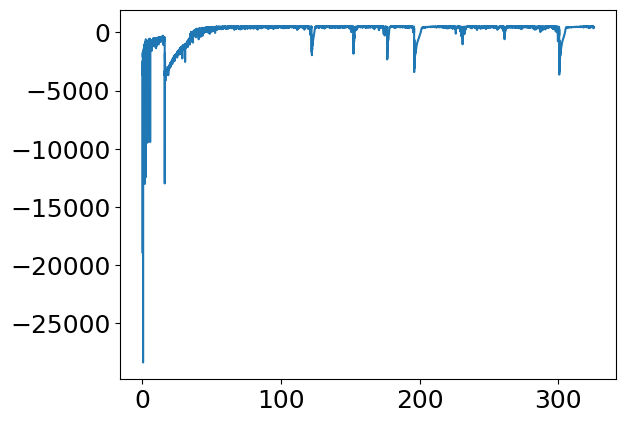

In [259]:
# ELBO
plt.plot(time_array[10:], -loss_array[10:])
print(np.mean(-loss_array[-150:]))
plt.show()

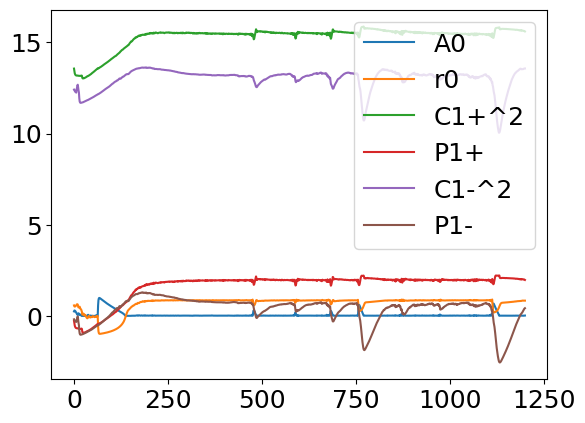

In [260]:
# Means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

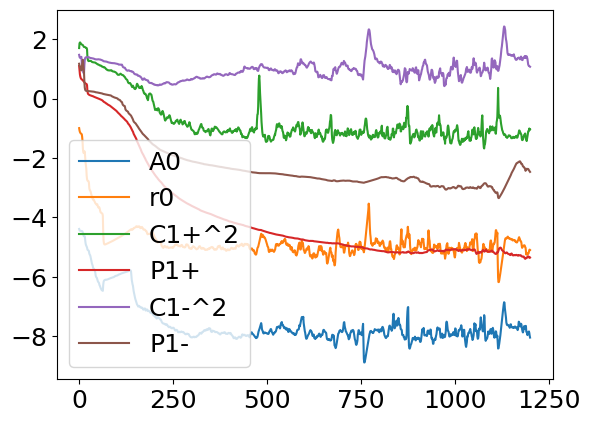

In [261]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

### Posteriors

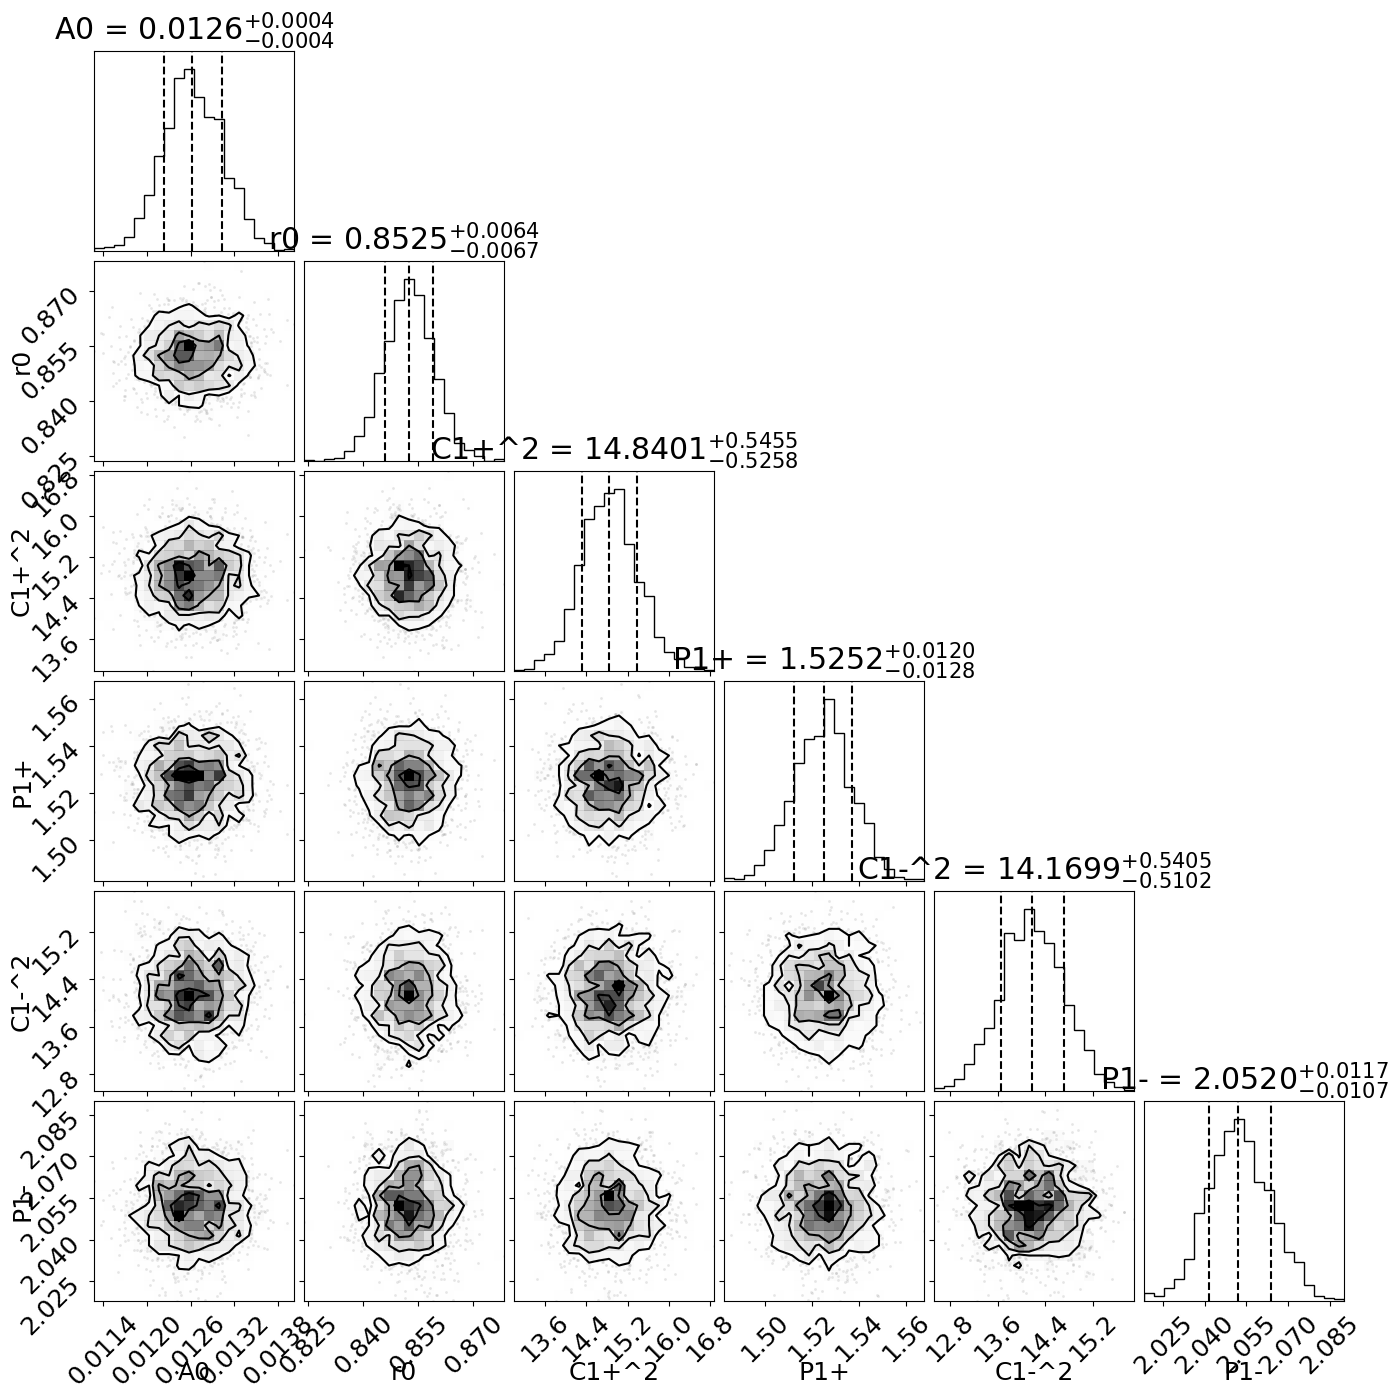

In [77]:
# VI Psoteriors
model.nMC = 2000
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
#g = sns.PairGrid(samples)
#g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
#g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
#plt.show()
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

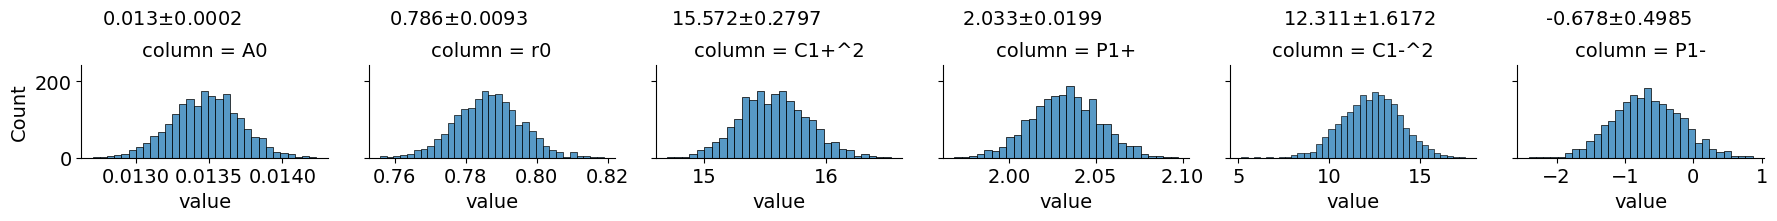

In [39]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

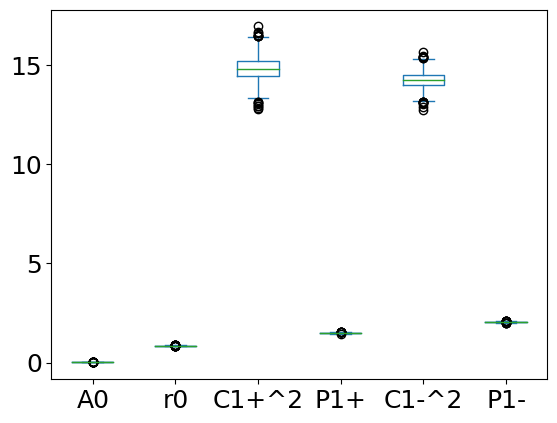

In [11]:
samples.plot(kind = "box")
plt.show()

### Posteriors - Multiple runs

In [262]:
folder = "Outputs"

ELBO = {}
posteriors = {}

for seed in range(15):
    run_id = "som_mf_" + str(seed) + "_"
    with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
        dictionary_outputs = pkl.load(handle)
    time_array = dictionary_outputs["time"]
    loss_array = - dictionary_outputs["ELBO"]
    ELBO[run_id] = loss_array
    param_dictionary = copy.deepcopy(dictionary_outputs)
    posteriors[run_id] = param_dictionary

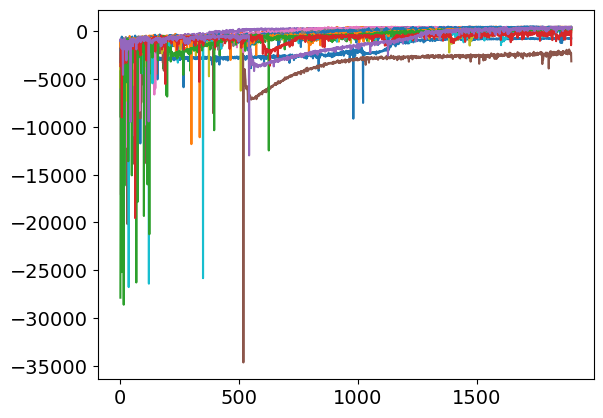

In [288]:
weights = {}
for index, (key, value) in enumerate(ELBO.items()):
    plt.plot(- value[100:2000])
    weights[key] = np.mean(- value[-3000:])
plt.show()
weights = pd.DataFrame(weights.items())
weights.columns = ["id", "ELBO"]
weights["p"] = np.exp(weights["ELBO"]) / np.sum(np.exp(weights["ELBO"]))
weights["pCum"] = np.cumsum(weights["p"])

In [289]:
weights["p"]

0     0.000000e+00
1     5.638591e-30
2     2.701741e-11
3     5.051610e-07
4     6.398677e-13
5     0.000000e+00
6     2.214119e-27
7     1.385609e-06
8     2.614086e-06
9     1.802954e-02
10    8.675163e-16
11    7.688365e-01
12    2.131293e-01
13    7.250410e-08
14    2.989246e-37
Name: p, dtype: float64

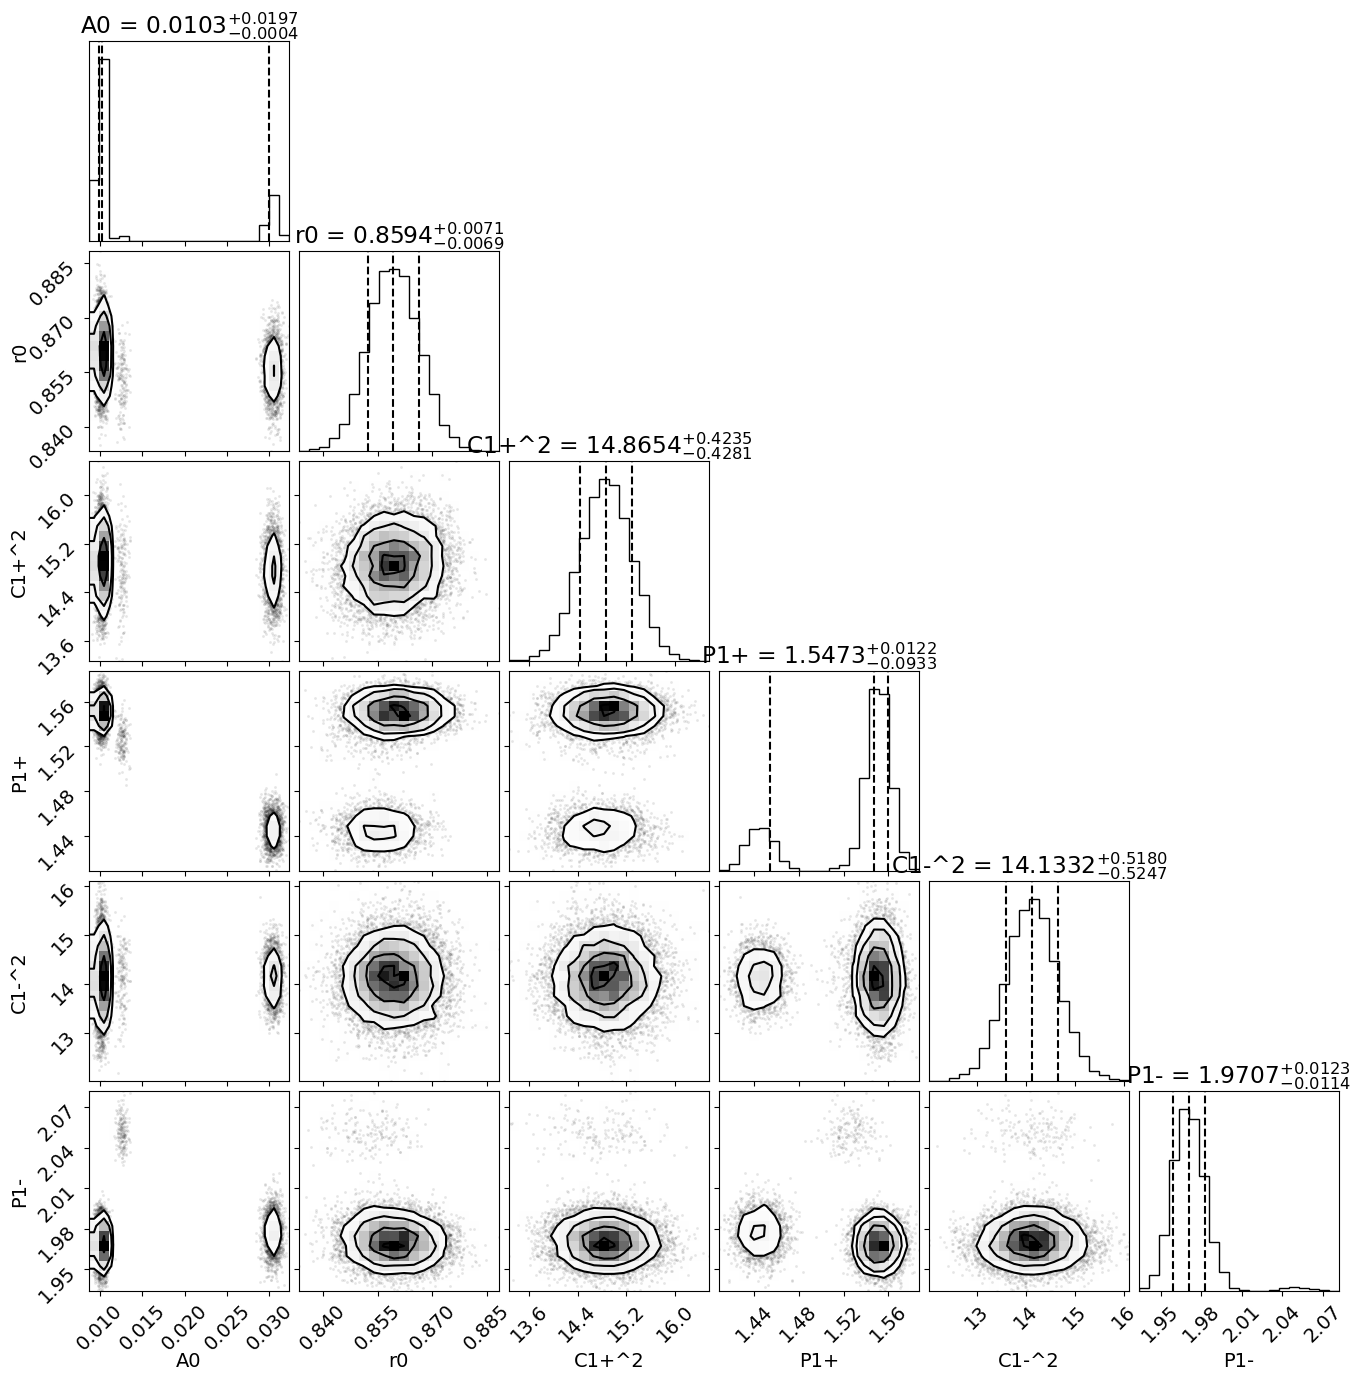

In [290]:
# VI Psoteriors
samples = 10000
theta = np.zeros((samples, model.param_dim + model.f_dim))
indices_array = np.zeros(samples)
for i in range(samples):
    u = np.random.uniform()
    states = (weights["pCum"] - u) > 0
    index_model = str(np.where(states)[0][0])
    indices_array[i] = np.where(states)[0][0]
    #index_model = str(9)
    #print(index)
    model.nMC = 1
    z = model.generate_sample(n_var = model.param_dim + model.f_dim)
    theta[i,:]  = model.sample_reparam_normal(z, torch.tensor(posteriors['som_mf_'+ index_model + '_']['q_theta_m'][-1]), torch.tensor(posteriors['som_mf_'+ index_model + '_']['q_theta_s'][-1])).numpy().flatten()

samples = pd.DataFrame(theta[:,:6], columns = names)
#g = sns.PairGrid(samples)
#g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
#g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
#plt.show()
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

In [291]:
pd.DataFrame(indices_array).value_counts()

11.0    7659
12.0    2157
9.0      184
dtype: int64

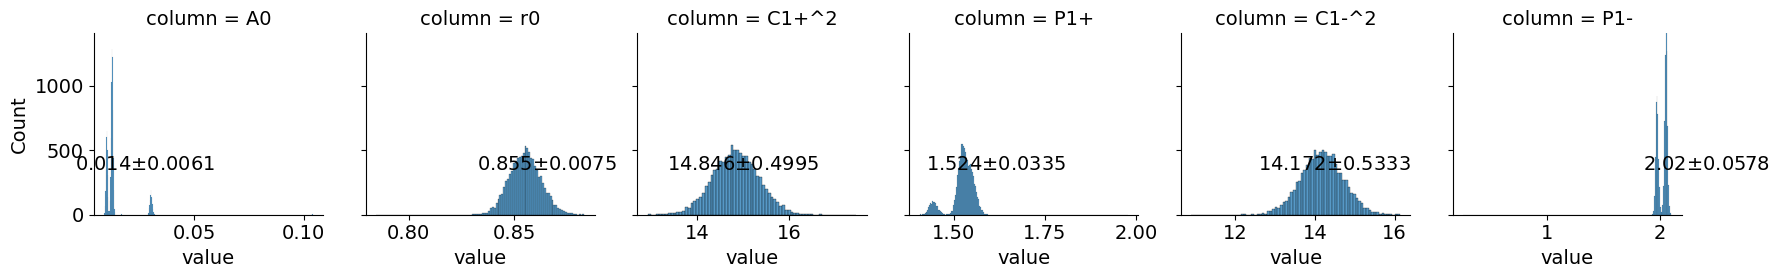

In [287]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

# Full covariance fit and analysis

In [14]:
seeds = [20, 21, 22, 23, 24]
for seed in seeds:
    torch.manual_seed(seed)

    ### Data 
    x_train = torch.tensor(data_train.theta_cs)
    y_train = torch.tensor(data_train.cs_data)

    ### torch.nn.Module class instance
    nMC = 5
    param_dim = 6
    x_dim = 1

    model = MCElboFG(nMC = nMC, x_dim = x_dim,
                     param_dim = param_dim,
                     f_dim = data_train.f_bounds.shape[0],
                     theta_cs = data_train.theta_cs,
                     err_cs = data_train.err_cs,
                     Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, cov_theory = True, recompute_values = True,
                     which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

    learning_rate = 5e-3
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_steps = 30000
    # Saving intermediate results
    loss_array = np.zeros(n_steps)
    time_array = np.zeros(n_steps)
    param_dictionary = {}
    for name, param in model.named_parameters():
        param_dictionary[name] = []

    startTime = time.time()
    for t in range(n_steps):
        # Compute ELBO
        loss = - model.compute_elbo_loop(x_train, y_train)
        # Zero gradinets
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        optimizer.step()

        # Utiliti computation
        loss_array[t] = loss.item()
        time_array[t] = time.time() - startTime 

        if t % 10 == 9: 
            for name, param in model.named_parameters():
                param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]

        if t % 2000 == 1999:
            print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
            print(model.ModelString())
            # Time estimmate
            print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

    endTime = time.time()
    print(endTime - startTime)

    folder = "Outputs"
    run_id = "som_full_" + str(seed) + "_"

    if not os.path.exists(folder):
        os.makedirs(folder)

    dictionary_outputs = copy.deepcopy(param_dictionary)
    dictionary_outputs["ELBO"] = -loss_array
    dictionary_outputs["time"] = time_array
    with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
        pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

Loss: 20422.880859375, Step [1999/30000]
theta mean: Parameter containing:
tensor([[ 0.1013,  0.7293, 13.6366, -0.1573, 12.5286, -0.0217,  0.9473,  0.9019,
          1.0486,  1.0086,  1.0421,  1.0522,  1.0615]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0165, 0.3460, 1.6800, 1.5440, 1.8478, 1.5534, 0.0242, 0.0223, 0.0313,
         0.0216, 0.0288, 0.0242, 0.0167]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 11.29973270372687
Loss: 1158.6500244140625, Step [3999/30000]
theta mean: Parameter containing:
tensor([[ 0.0878,  0.7031, 13.3606, -0.3956, 12.2480, -0.2717,  0.9573,  0.9123,
          1.0582,  1.0257,  1.0755,  1.0912,  1.1003]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0179, 0.3224, 1.6835, 1.3875, 1.7224, 1.2590, 0.0121, 0.0107, 0.0153,
         0.0109, 0.0137, 0.0127, 0.0089]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 10.884897883226348
Loss: 676.59655761

Loss: 508.4183654785156, Step [5999/30000]
theta mean: Parameter containing:
tensor([[ 0.0273,  0.3627, 13.2393, -0.6433, 11.8774, -0.6297,  0.9719,  0.9345,
          1.1020,  1.0998,  1.1688,  1.2133,  1.2259]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0239, 0.1604, 1.6353, 0.9875, 1.8383, 0.9703, 0.0066, 0.0068, 0.0083,
         0.0064, 0.0066, 0.0080, 0.0066]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 11.037925358888884
Loss: 8029.3525390625, Step [7999/30000]
theta mean: Parameter containing:
tensor([[ 0.0450,  0.2835, 13.2743, -0.6182, 12.0808, -0.4729,  0.9681,  0.9223,
          1.0924,  1.0785,  1.1391,  1.1808,  1.1907]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0205, 0.0998, 1.6174, 0.8331, 1.7345, 0.8599, 0.0054, 0.0047, 0.0053,
         0.0045, 0.0044, 0.0051, 0.0043]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 10.118065379056581
Loss: 433.45547485

Loss: 556.91064453125, Step [9999/30000]
theta mean: Parameter containing:
tensor([[ 0.0317,  0.2721, 13.1970, -0.6254, 12.2958, -0.3955,  0.9722,  0.9254,
          1.1032,  1.0882,  1.1564,  1.2072,  1.2151]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0207, 0.1511, 1.1122, 0.7237, 1.6272, 0.7855, 0.0054, 0.0038, 0.0035,
         0.0034, 0.0033, 0.0034, 0.0031]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 9.258583904764798
Loss: 396.26922607421875, Step [11999/30000]
theta mean: Parameter containing:
tensor([[ 0.0395,  0.0831, 13.7382, -0.2142, 12.9340,  0.2705,  0.9551,  0.9099,
          1.0700,  1.0539,  1.1121,  1.1457,  1.1552]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0194, 0.0927, 1.0596, 0.6588, 1.4931, 0.6830, 0.0051, 0.0035, 0.0028,
         0.0032, 0.0027, 0.0031, 0.0027]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 8.277027308946517
Loss: 214.95893859

Loss: 177.9669952392578, Step [13999/30000]
theta mean: Parameter containing:
tensor([[ 0.0839,  0.5427, 14.9032,  1.2296, 13.8083,  1.1583,  0.9310,  0.8697,
          1.0016,  0.9610,  0.9753,  0.9546,  0.9660]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0111, 0.0743, 1.3147, 0.3108, 1.4828, 0.4091, 0.0052, 0.0042, 0.0031,
         0.0032, 0.0025, 0.0029, 0.0023]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 7.471661038530961
Loss: -138.12001037597656, Step [15999/30000]
theta mean: Parameter containing:
tensor([[ 0.0164,  0.8704, 15.1348,  1.5659, 14.1323,  1.7997,  0.9745,  0.9252,
          1.0673,  1.0136,  1.0300,  1.0155,  1.0268]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0092, 0.0356, 1.3024, 0.1731, 1.4363, 0.1704, 0.0055, 0.0036, 0.0029,
         0.0030, 0.0024, 0.0026, 0.0022]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 6.514025445367867
Loss: -152.531

Loss: -417.23760986328125, Step [15999/30000]
theta mean: Parameter containing:
tensor([[ 0.0167,  0.8006, 15.0503,  1.3441, 13.8930,  1.9201,  0.9727,  0.9238,
          1.0620,  1.0127,  1.0346,  1.0223,  1.0240]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0056, 0.0236, 1.3105, 0.2053, 1.2151, 0.1690, 0.0056, 0.0035, 0.0028,
         0.0028, 0.0023, 0.0025, 0.0024]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 6.573362154867941
Loss: -452.55694580078125, Step [17999/30000]
theta mean: Parameter containing:
tensor([[1.3587e-02, 8.4656e-01, 1.5154e+01, 1.5811e+00, 1.3506e+01, 1.8529e+00,
         9.7915e-01, 9.2829e-01, 1.0622e+00, 1.0121e+00, 1.0393e+00, 1.0194e+00,
         1.0390e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0041, 0.0179, 1.3193, 0.1367, 1.1519, 0.1082, 0.0055, 0.0038, 0.0031,
         0.0030, 0.0021, 0.0025, 0.0021]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes

## Loading results

In [109]:
folder = "Outputs"
run_id = "som_full_3_"

with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
    dictionary_outputs = pkl.load(handle)
time_array = dictionary_outputs["time"]
loss_array = - dictionary_outputs["ELBO"]
param_dictionary = copy.deepcopy(dictionary_outputs)

## Fit plots

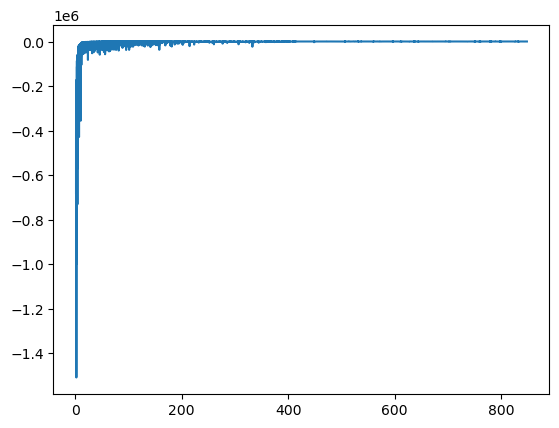

In [15]:
# ELBO
plt.plot(time_array[50:], -loss_array[50:])
plt.show()

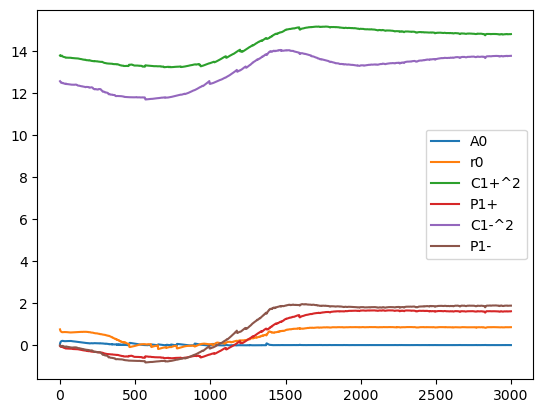

In [16]:
# means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

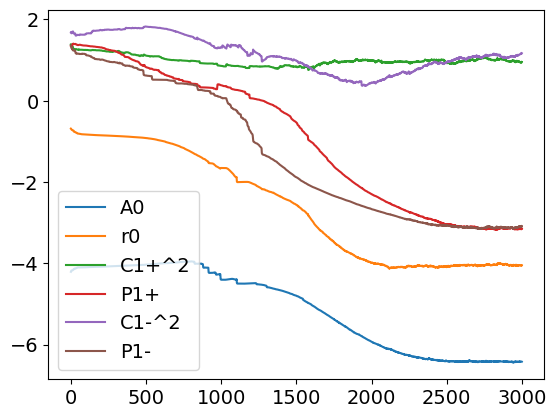

In [352]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

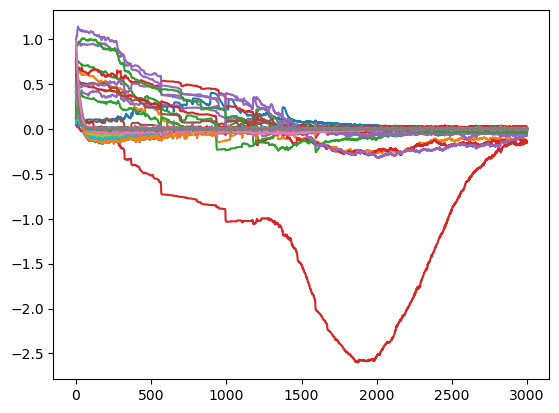

In [17]:
# Cholesky factor components for covariance matrix
plt.plot(np.array(param_dictionary["q_theta_c"])[:,0,:])
plt.show()

### Posteriors - Multiple runs

In [18]:
folder = "Outputs"

ELBO = {}
posteriors = {}

for seed in range(25):
    run_id = "som_full_" + str(seed) + "_"
    with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
        dictionary_outputs = pkl.load(handle)
    time_array = dictionary_outputs["time"]
    loss_array = - dictionary_outputs["ELBO"]
    ELBO[run_id] = loss_array
    param_dictionary = copy.deepcopy(dictionary_outputs)
    posteriors[run_id] = param_dictionary

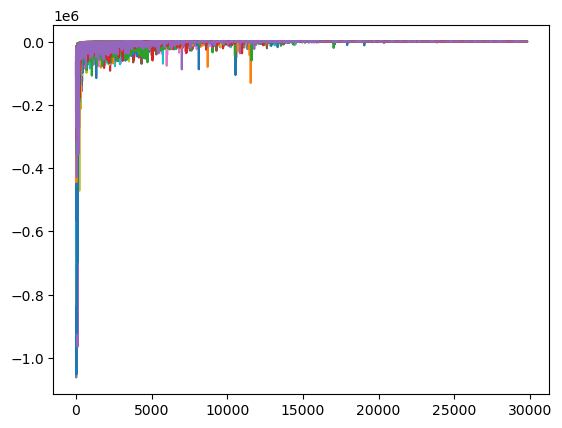

In [38]:
weights = {}
for index, (key, value) in enumerate(ELBO.items()):
    plt.plot(- value[200:])
    weights[key] = np.mean(- value[-10000:])
plt.show()
weights = pd.DataFrame(weights.items())
weights.columns = ["id", "ELBO"]
weights["p"] = np.exp(weights["ELBO"]) / np.sum(np.exp(weights["ELBO"]))
weights["pCum"] = np.cumsum(weights["p"])

In [34]:
weights

,id,ELBO,p,pCum
0,som_full_0_,419.198758,4.956251e-13,4.956251e-13
1,som_full_1_,437.815906,6.032234e-05,6.032234e-05
2,som_full_2_,446.790704,4.766318e-01,4.766921e-01
3,som_full_3_,443.456561,1.698961e-02,4.936817e-01
4,som_full_4_,442.589380,7.137915e-03,5.008197e-01
5,som_full_5_,442.866969,9.421648e-03,5.102413e-01
6,som_full_6_,443.662426,2.087322e-02,5.311145e-01
7,som_full_7_,442.669718,7.735027e-03,5.388496e-01
8,som_full_8_,444.188167,3.531146e-02,5.741610e-01
9,som_full_9_,443.617851,1.996322e-02,5.941242e-01


<AxesSubplot:>

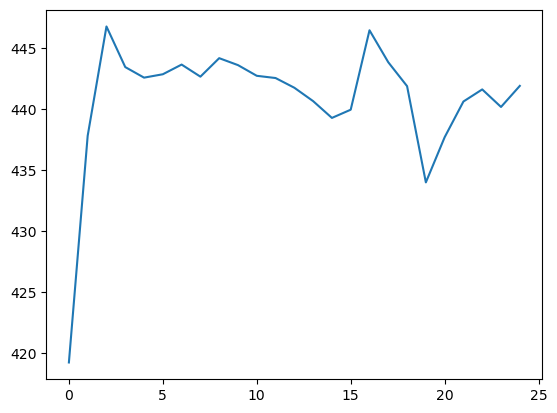

In [42]:
weights["ELBO"].plot()

<AxesSubplot:>

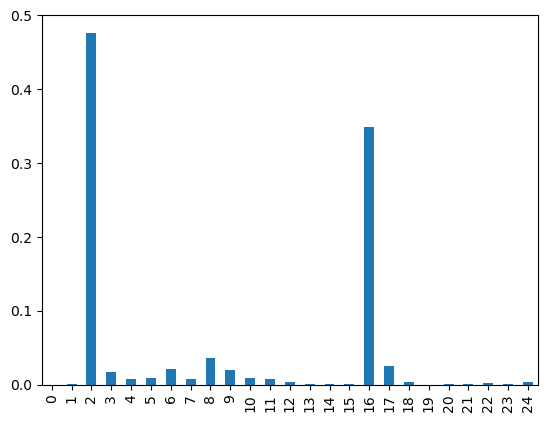

In [47]:
weights["p"].plot.bar()

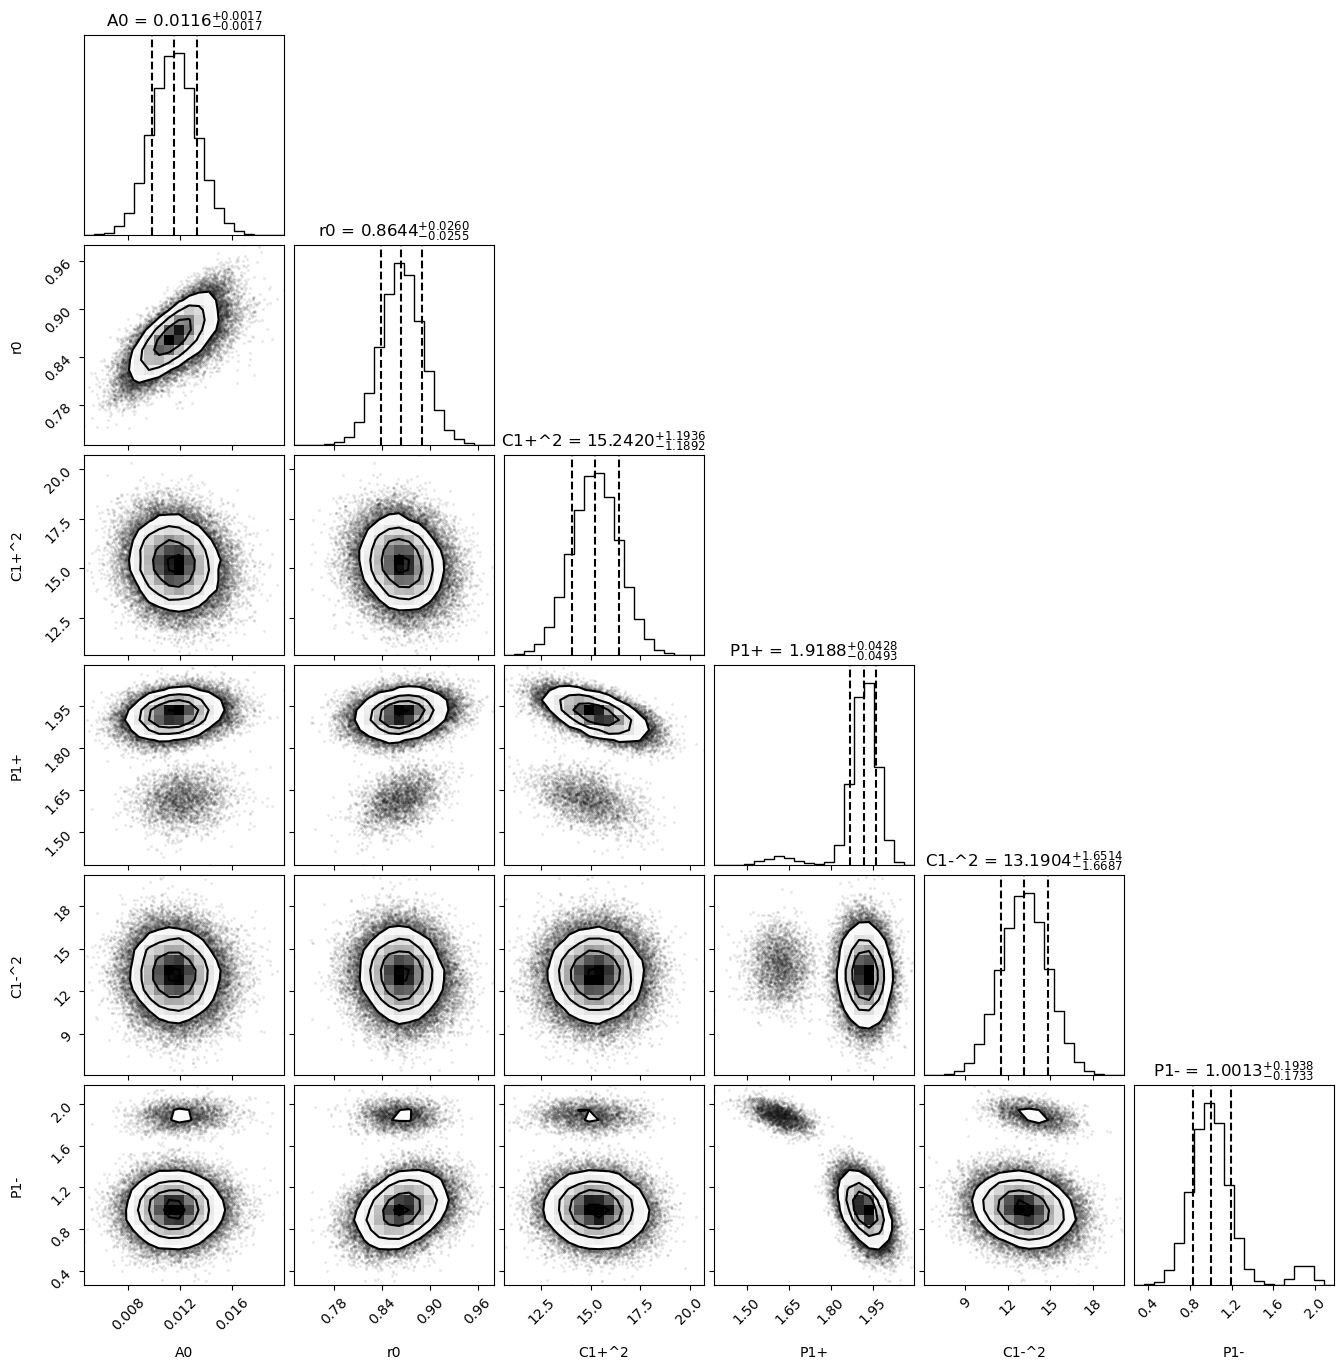

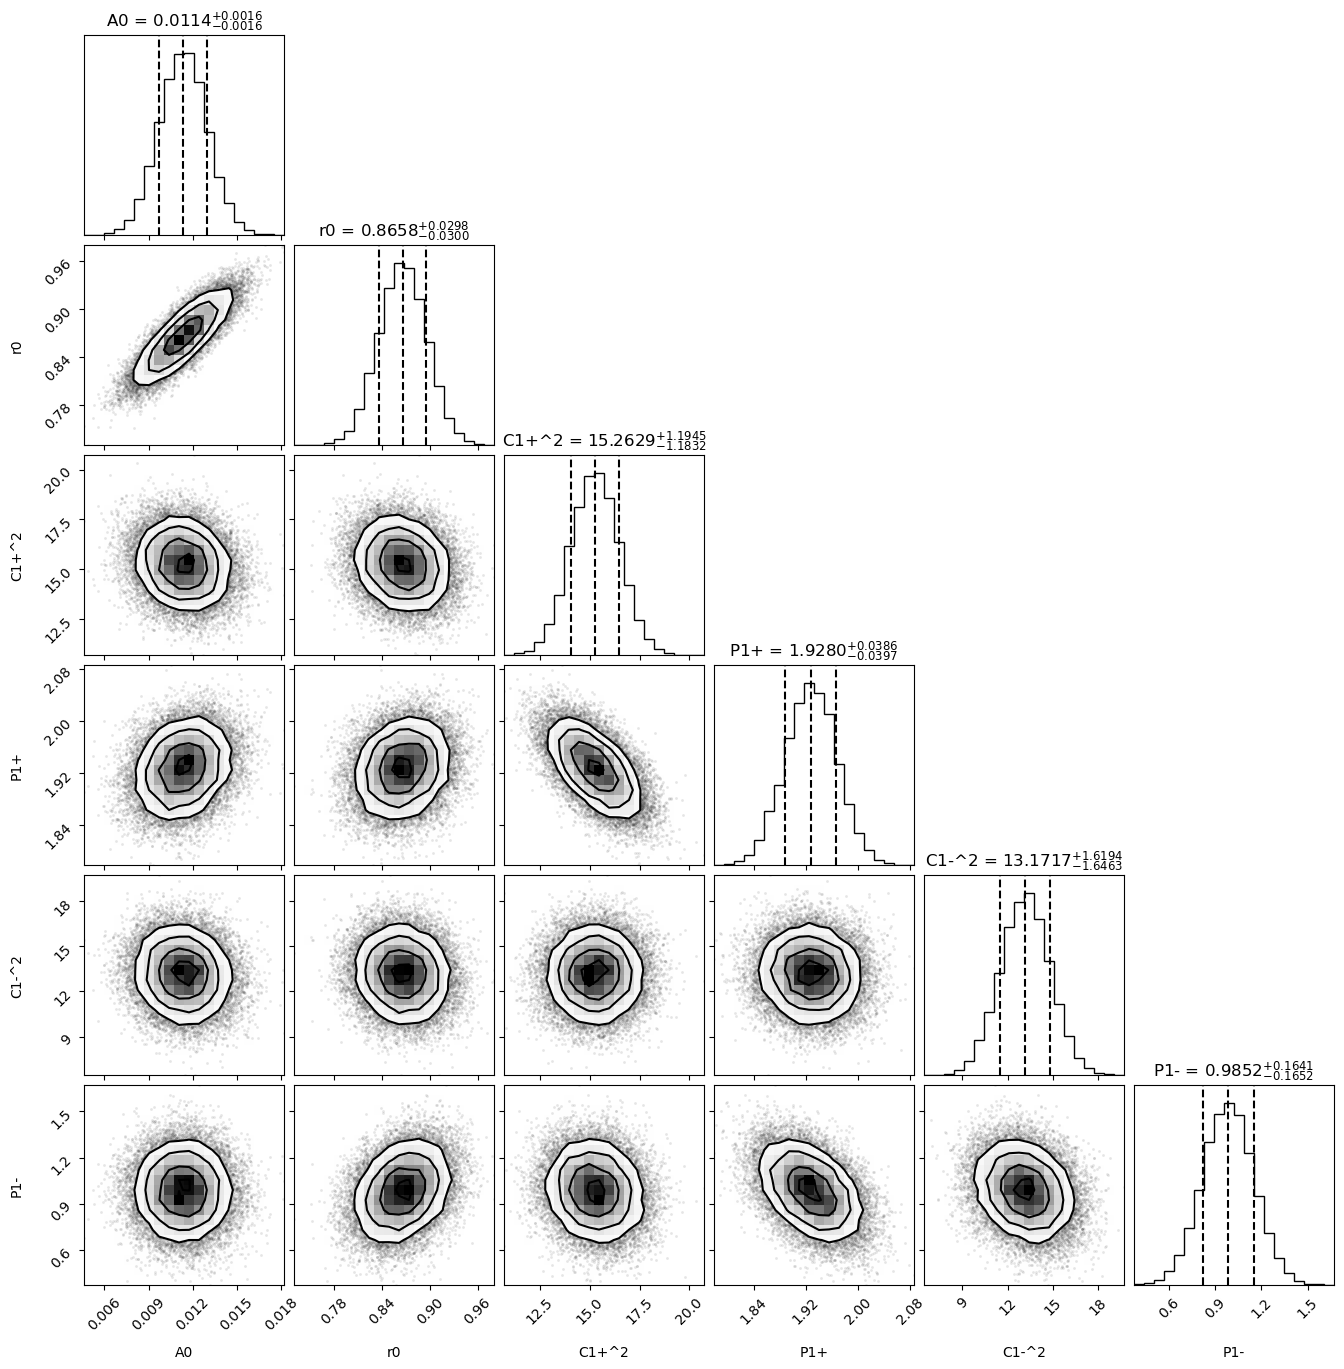

In [45]:
# VI Psoteriors
samples = 50000
theta = np.zeros((samples, model.param_dim + model.f_dim))
indices_array = np.zeros(samples)
for i in range(samples):
    u = np.random.uniform()
    states = (weights["pCum"] - u) > 0
    index_model = str(np.where(states)[0][0])
    indices_array[i] = np.where(states)[0][0]
    #index_model = str(2)
    #print(index)
    model.nMC = 1
    z = model.generate_sample(n_var = model.param_dim + model.f_dim)
    U = torch.zeros((model.param_dim + model.f_dim ,model.param_dim + model.f_dim), dtype=torch.float64)
    U[model.up_i] = torch.tensor(posteriors['som_full_'+ index_model + '_']['q_theta_c'][-1])
    U[model.diag_i] = model.softplus(torch.tensor(posteriors['som_full_'+ index_model + '_']['q_theta_s'][-1]))
    L = U.T
    theta[i,:]  = model.sample_reparam_normal(z[0,:,:], torch.tensor(posteriors['som_full_'+ index_model + '_']['q_theta_m'][-1]), L).numpy().flatten() 

samples = pd.DataFrame(theta[:,:6], columns = names)
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()
# Top model
samples = pd.DataFrame(theta[indices_array == 2,:6], columns = names)
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

In [30]:
pd.DataFrame(indices_array).value_counts()

2.0     24011
16.0    17229
8.0      1808
17.0     1271
6.0      1014
9.0       988
3.0       860
5.0       468
7.0       405
10.0      388
11.0      366
4.0       355
24.0      189
18.0      188
12.0      161
22.0      119
21.0       56
13.0       50
23.0       29
15.0       25
14.0       13
1.0         4
20.0        3
dtype: int64

### Correlations

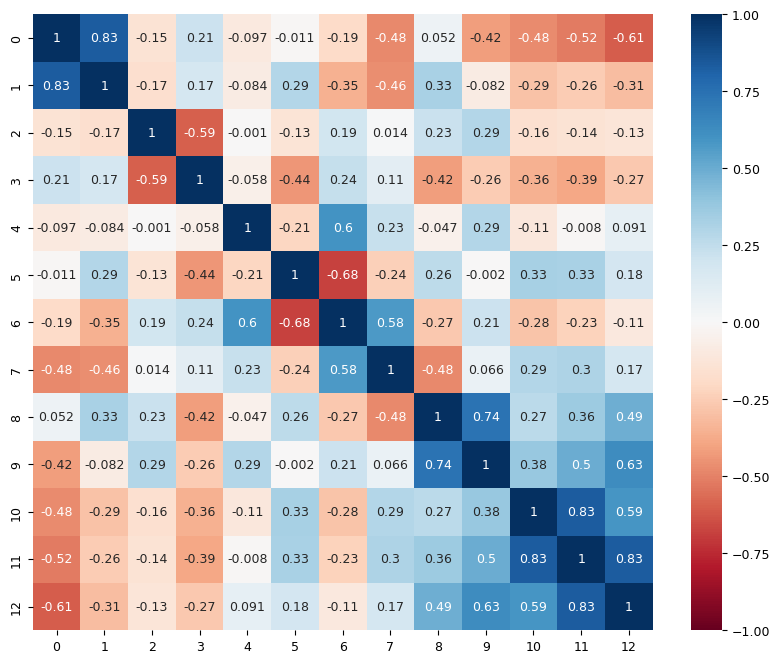

In [27]:
# All parameters
L = model.cholesky_factor()
S = L @ L.T
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 9})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3), vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

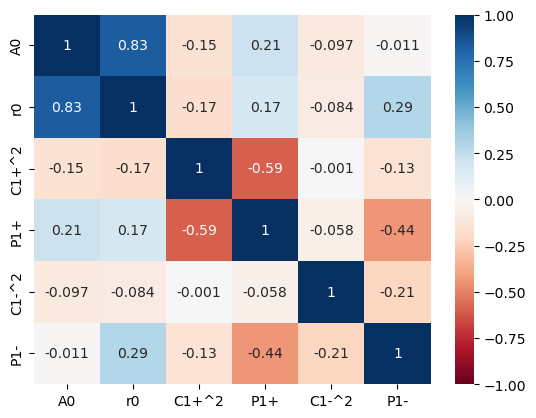

In [28]:
# Calibration parameters only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(pd.DataFrame(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[:6,:6], columns = names, index = names), vmin=-1, vmax=1, annot=True, cmap=cmap)
plt.show()

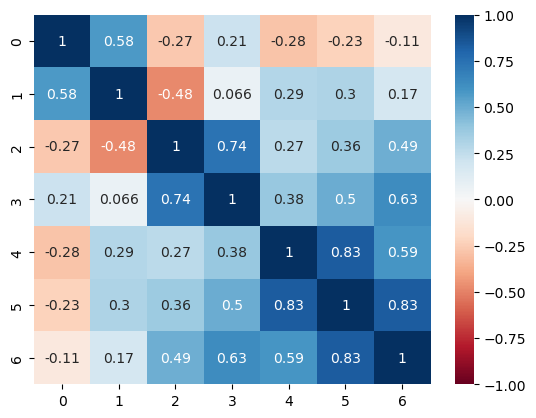

In [29]:
# Normalizing factors only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[6:,6:], vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

### Posteriors

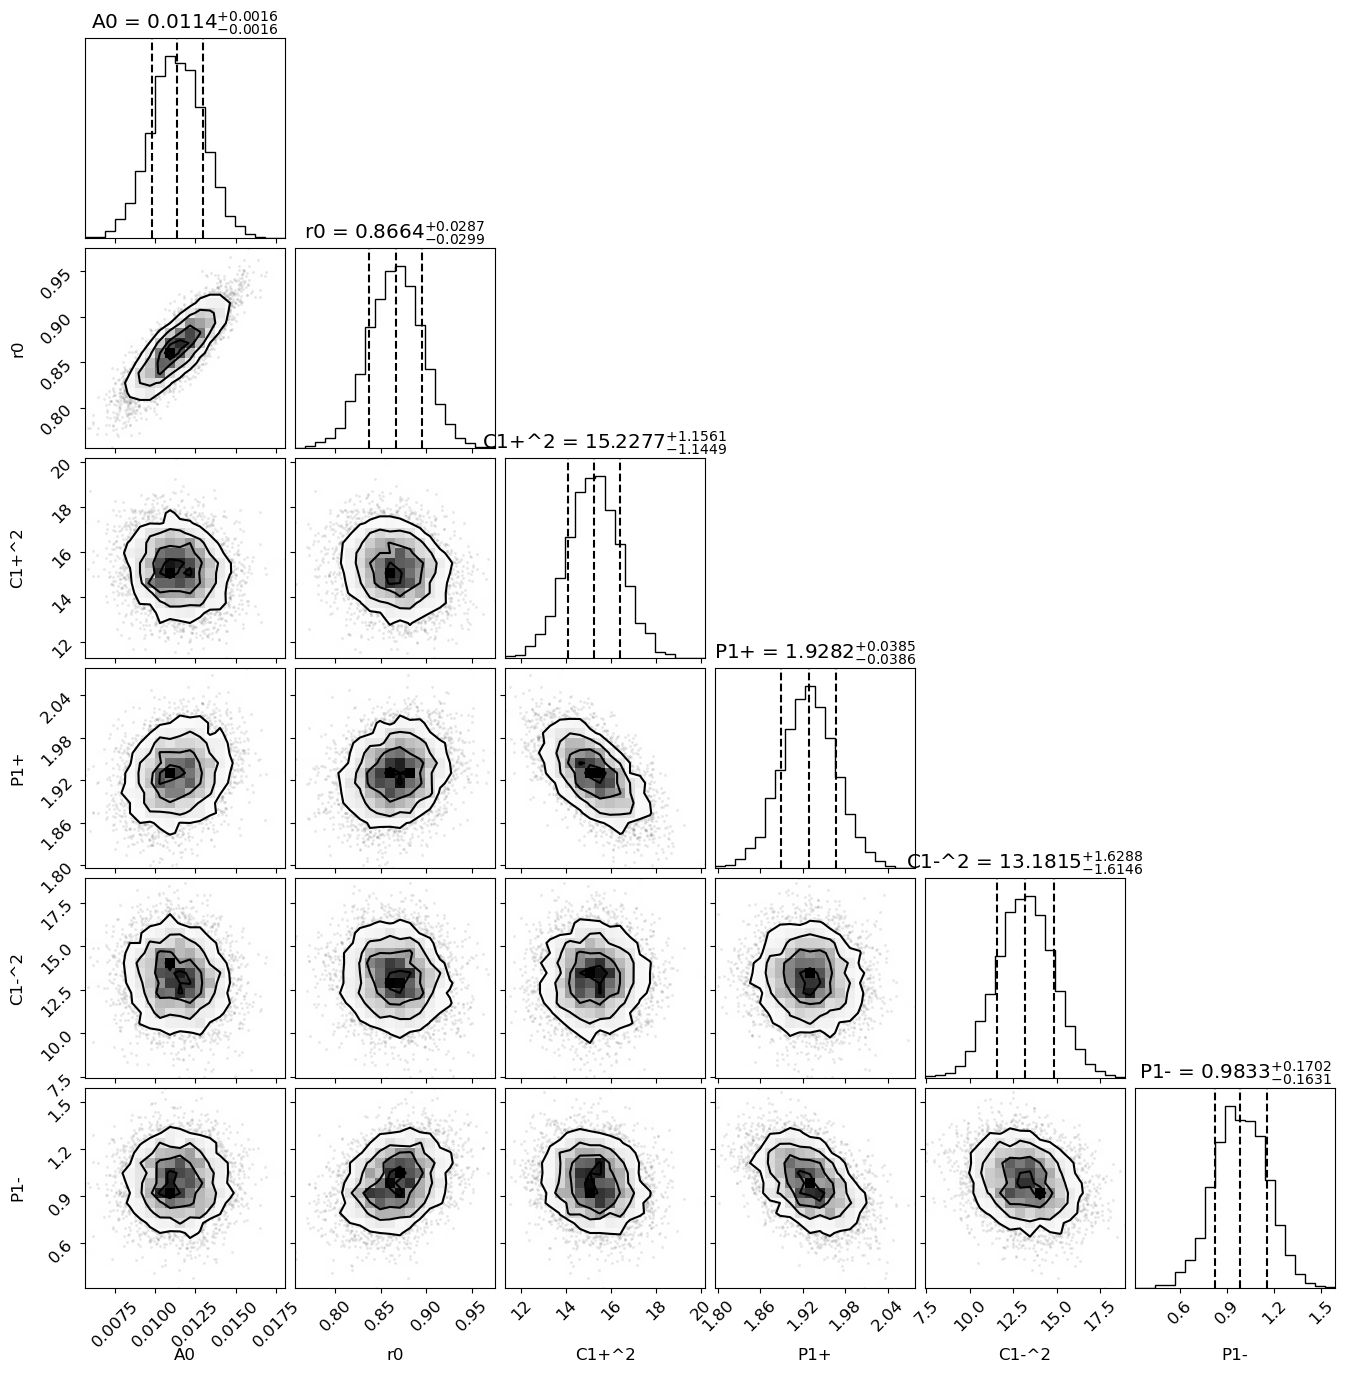

In [30]:
# VI Psoteriors
model.nMC = 5000
L = model.cholesky_factor()
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, L)   

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 12})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
#g = sns.PairGrid(samples)
#g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
#g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
#plt.show()

corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

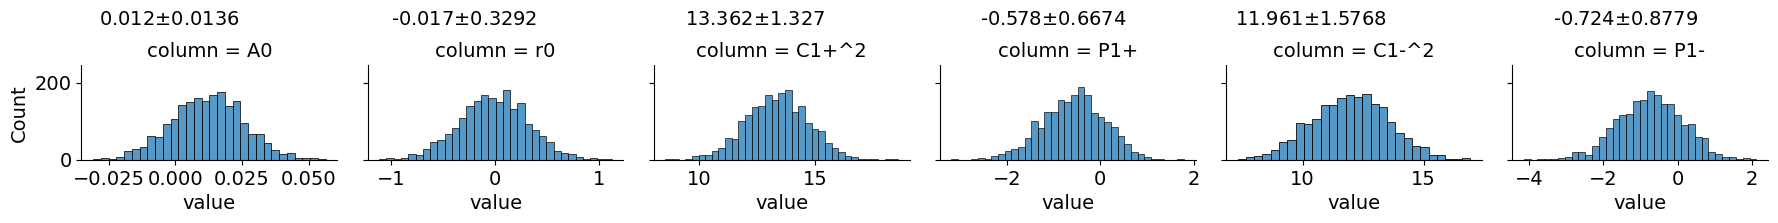

In [50]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

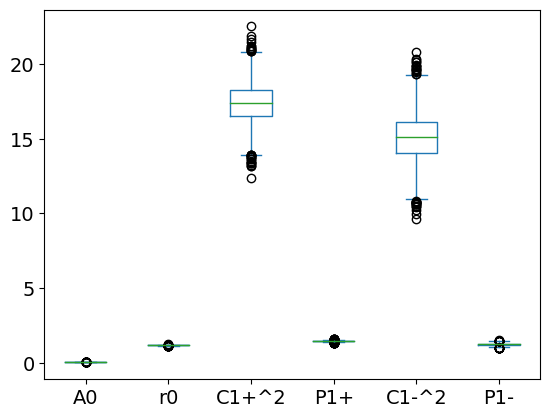

In [42]:
samples.plot(kind = "box")
plt.show()